In [140]:
images_path = "_image"
masks_path = "_mask"

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [141]:
images = []
masks = []
for i in range(0,40):
    image_name = f"{i+1}.tif"
    mask_name = f"{i+1}.png"
    image = plt.imread(os.path.join(images_path, image_name))
    mask = plt.imread(os.path.join(masks_path, mask_name))
    mask=np.where(mask>0,1,0)
    # binarize the mask
    images.append(image)
    masks.append(mask)
# ROSSA
# for i in range(301,350): #919
#     image_name = f"{i}.png"
#     mask_name = f"{i}.png"
#     # resize to 512x512

#     image = plt.imread(os.path.join(images_path, image_name))
#     mask = plt.imread(os.path.join(masks_path, mask_name))
#     image = cv2.resize(image, (512, 512))
#     mask = cv2.resize(mask, (512, 512))
#     mask=np.where(mask>0,1,0)
#     # binarize the mask
#     images.append(image)
#     masks.append(mask)

    # Kodiak images
for i in range(0,22):
    image_name = f"slo_{i+1}.tiff"
    mask_name = f"vessels_{i+1}.tiff"
    image = plt.imread(os.path.join(images_path, image_name))
    # add a channel dimension if necessary
    if image.ndim == 2:
        # convert to rgb
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # convert to grayscale if necessary
    mask = plt.imread(os.path.join(masks_path, mask_name))
    mask=np.where(mask>0,1,0)
    # binarize the mask
    images.append(image)
    masks.append(mask)


# Kodiak Images
for i in range(0,6):
    image_name = f"bad{i+1}.tif"
    mask_name = f"bad{i+1}.tif"
    image = plt.imread(os.path.join(images_path, image_name))
    # add a channel dimension if necessary
    if image.ndim == 2:
        # convert to rgb
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # convert to grayscale if necessary
    mask = plt.imread(os.path.join(masks_path, mask_name))
    mask=np.where(mask>0,1,0)
    # binarize the mask
    images.append(image)
    masks.append(mask)
    
for i in range(0,23):
    image_name = f"i{i+1}.png"
    mask_name = f"i{i+1}.png"
    image = plt.imread(os.path.join(images_path, image_name))
    # add a channel dimension if necessary
    if image.ndim == 2:
        # convert to rgb
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # convert to grayscale if necessary
    mask = plt.imread(os.path.join(masks_path, mask_name))
    mask=np.where(mask>0,1,0)
    # binarize the mask
    images.append(image)
    masks.append(mask)

# Display the first image and its corresponding mask
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(images[75])
# plt.title("Original Image")
# plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(masks[75], cmap="gray")
# plt.title("Mask")
# plt.axis("off")

plt.show()

In [142]:
def histo_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    assert (imgs.shape[1] == 1)  # check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = cv2.equalizeHist(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = clahe.apply(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs - imgs_mean) / imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (
                    np.max(imgs_normalized[i]) - np.min(imgs_normalized[i]))) * 255
    return imgs_normalized

def adjust_gamma_batch(imgs, gamma=1.0):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i, 0] = cv2.LUT(np.array(imgs[i, 0], dtype=np.uint8), table)
    return new_imgs

def rgb2gray(rgb):
    assert (len(rgb.shape) == 4)  # 4D arrays
    assert (rgb.shape[1] == 3)
    bn_imgs = rgb[:, 1, :, :] * 0.75 + rgb[:, 2, :, :] * 0.25
    bn_imgs = np.reshape(bn_imgs, (rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

def preprocess_batch(data):
    assert (len(data.shape) == 4)
    assert (data.shape[1] == 3)  # Use the original images
    train_imgs = rgb2gray(data)
    # my preprocessing:
    train_imgs = dataset_normalized_batch(train_imgs)
    train_imgs = clahe_equalized_batch(train_imgs)
    train_imgs = adjust_gamma_batch(train_imgs, 1.2)
    return train_imgs

image_list=[]
for image in images:
    print(f"Processing image of shape: {image.shape}")
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.transpose(0, 3, 1, 2)           # (1, 3, H, W)
    image = preprocess_batch(image)
    image_list.append(image)



Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image of shape: (584, 565, 3)
Processing image

(136500, 64, 64, 1) (136500, 64, 64, 1)


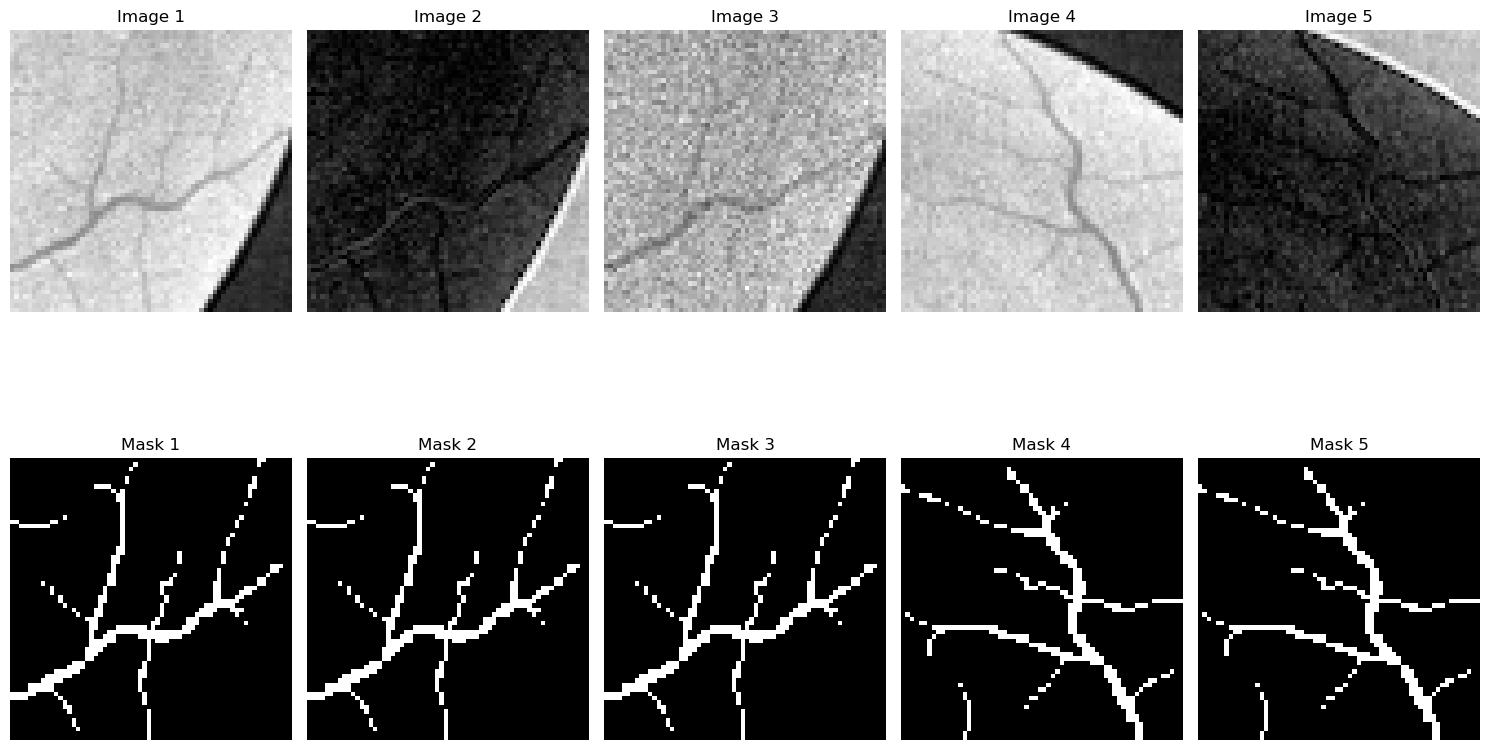

In [143]:
img_train_path = "train_images2"
masks_train_path = "train_masks2"

if not os.path.exists(img_train_path):
    os.makedirs(img_train_path)
if not os.path.exists(masks_train_path):
    os.makedirs(masks_train_path)

def augment_images(patch_images, patch_masks):
    augmented_images = []
    masks = []
    for mask,image in zip(patch_masks, patch_images):
        augmented_images.append(image)
        masks.append(mask)

        # dark
        darkened_image = cv2.convertScaleAbs(image, alpha= np.random.uniform(0.8, .95), beta=-100)
        augmented_images.append(darkened_image)
        masks.append(mask)  # No change to mask when darkening

        lam = 200
        img_norm = image.astype(np.float32) / 255.0

        scaled = img_norm * lam

        noisy_counts = np.random.poisson(scaled)

        noisy = noisy_counts / lam
        noisy = np.clip(noisy, 0.0, 1.0)

        augmented_images.append((noisy * 255).astype(np.uint8))
        masks.append(mask)
    # plt.figure(figsize=(15, 10))
    # for i in range(10):
    #     plt.subplot(2, 5, i + 1)
    #     plt.imshow(augmented_images[i], cmap='gray')
    #     plt.title(f"Image {i+1}")
    #     plt.axis("off")

    #     plt.subplot(2, 5, i + 6)
    #     plt.imshow(masks[i], cmap='gray')
    #     plt.title(f"Mask {i+1}")
    #     plt.axis("off")
    return augmented_images, masks



np.random.seed(42)  # For reproducibility
def make_imgs(images, masks, final_size=64, num_samples=100):
    patch_images, patch_masks = [], []
    for img, msk in zip(images, masks):
        # assume img shape = (1,1,H,W), msk shape = (H,W)
        H, W = img.shape[2], img.shape[3]
        for _ in range(num_samples):
            size=np.random.randint(64, 128) 

            x = np.random.randint(0, W - size)
            y = np.random.randint(0, H - size)
            # grab a (48×
            # 
            # ) slice directly
            patch = img[0, 0, y:y+size, x:x+size]     # → shape (48,48)
            mask  = msk[y:y+size, x:x+size]           # → shape (48,48)
            patch = cv2.resize(patch, (final_size, final_size))  # Resize to (48, 48)
            mask = cv2.resize(mask, (final_size, final_size),     interpolation=cv2.INTER_NEAREST)      # Resize to
            patch_images.append(patch)
            patch_masks.append(mask)

            rotated_patch = np.rot90(patch, k=1, axes=(0, 1))
            rotated_mask = np.rot90(mask, k=1, axes=(0, 1))
            patch_images.append(rotated_patch)
            patch_masks.append(rotated_mask)

            horizontal_flip = np.fliplr(patch)
            horizontal_mask_flip = np.fliplr(mask)
            patch_images.append(horizontal_flip)
            patch_masks.append(horizontal_mask_flip)

            vertical_flip = np.flipud(patch)
            vertical_mask_flip = np.flipud(mask)
            patch_images.append(vertical_flip)
            patch_masks.append(vertical_mask_flip)

            kernel = np.ones((5, 5), np.float32) / 25
            blur = cv2.filter2D(patch, -1, kernel)  # Apply the filter
            patch_images.append(blur)
            patch_masks.append(mask)
    return patch_images, patch_masks

patch_images, patch_masks = make_imgs(image_list, masks)
patch_images, patch_masks = augment_images(patch_images, patch_masks)
# stack into arrays for training:
X = np.stack(patch_images)      # (N,48,48)
Y = np.stack(patch_masks)       # (N,48,48)

# add channel axis for Keras:
X = X[..., np.newaxis]          # (N,48,48,1)
Y = Y[..., np.newaxis]          # (N,48,48,1)

# cast/scale:
X = X.astype('float32')/255.0
Y = Y.astype('float32')         # (0.0 or 1.0)

print(X.shape, Y.shape)
# → e.g. (2000, 48, 48, 1) , (2000, 48, 48, 1)

# when saving to disk, write them as plain 2D uint8:
for i, (img, mask) in enumerate(zip(patch_images, patch_masks)):
    cv2.imwrite(f"train_images2/{i+1}.png", (img).astype(np.uint8))
    cv2.imwrite(f"train_masks2/{i+1}.png", (mask).astype(np.uint8))

# show first 5 images and masks
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(patch_images[i], cmap='gray')
    plt.title(f"Image {i+1}")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(patch_masks[i], cmap='gray')
    plt.title(f"Mask {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [144]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    AveragePooling2D, Conv2D, BatchNormalization, Activation,
    LeakyReLU, MaxPool2D, UpSampling2D, Concatenate, Add, Multiply
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split



In [145]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters, dropout_rate=None):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)
    return x

def down_block(x, filters, dropout_rate=None):
    x = conv_block(x, filters, dropout_rate)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def up_block(x, skip, filters, dropout_rate=None):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters, dropout_rate)
    return x

def fuse_features(s4, s3, s2, bottleneck):
    p4 = layers.UpSampling2D(size=(2, 2))(bottleneck)
    p4 = layers.Add()([s4, p4])  # 8x8

    p3 = layers.UpSampling2D(size=(2, 2))(p4)
    p3 = layers.Add()([s3, p3])  # 16x16

    p3_adjusted = layers.Conv2D(64, 1, padding='same')(p3)  # Adjust channels
    p2 = layers.UpSampling2D(size=(2, 2))(p3_adjusted)
    p2 = layers.Add()([s2, p2])  # 32x32

    return p2, p3, p4

def build_bifpn_unet(input_shape=(64, 64, 1), dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    s1, p1 = down_block(inputs, 32, dropout_rate)
    s2, p2 = down_block(p1, 64, dropout_rate)
    s3, p3 = down_block(p2, 128, dropout_rate)
    s4, p4 = down_block(p3, 128, dropout_rate)

    # Bottleneck
    bottleneck = conv_block(p4, 128, dropout_rate)

    # Fusion
    fused_p2, fused_p3, fused_p4 = fuse_features(s4, s3, s2, bottleneck)

    # Decoder
    u1 = up_block(fused_p4, fused_p3, 128, dropout_rate)
    u2 = up_block(u1, fused_p2, 64, dropout_rate)
    u3 = up_block(u2, s1, 32, dropout_rate)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u3)

    return models.Model(inputs, outputs, name='BiFPN_UNet_Dropout')


In [ ]:
EPOCHS = 100
LR = 5e-4
BATCH_SIZE = 32
def lbce_dice_loss(y_true, y_pred, eps=1e-6):
    """
    y_true: ground‐truth mask, shape (B, H, W, 1), values in {0,1}
    y_pred: predicted mask logits or probabilities, same shape
    """
    # flatten spatial dims to compute N and n per sample
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1))
    y_pred_f = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1))
    
    # per‐sample sums
    n = tf.reduce_sum(y_true_f, axis=1)                       # shape (B,)
    N = tf.cast(tf.shape(y_true_f)[1], tf.float32)           # scalar
    
    # 1) binary cross‐entropy per sample
    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f)  # shape (B,)
    
    # 2) dice loss per sample
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)      # shape (B,)
    dice_coef = (2. * intersection + eps) / (n + tf.reduce_sum(y_pred_f, axis=1) + eps)
    dice_loss = 1. - dice_coef                                     # shape (B,)
    
    # 3) weighting term per sample
    w_bce  = (N - n) / N    # shape (B,)
    w_dice = n     / N      # shape (B,)
    
    # 4) combined loss, then mean over batch
    loss_per_sample = w_bce * bce + w_dice * dice_loss            # shape (B,)
    return tf.reduce_mean(loss_per_sample)
# Data Preparation
# Stack & add channel dim, normalize
X = np.stack(patch_images)[..., np.newaxis].astype('float32') / 255.0
Y = np.stack(patch_masks)[..., np.newaxis].astype('float32')

# Split into train/validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")

# Create model
model = build_bifpn_unet(dropout_rate=0)
model.summary()

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    # loss=lbce_dice_loss,
    loss=lbce_dice_loss,

    metrics=['accuracy', Precision(), Recall()]
)

# Callbacks
os.makedirs('checkpoints', exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint(
        filepath='checkpoints/best_bifpn_model',
        monitor='val_loss',
        save_best_only=True,
        verbose=1,
        save_format="tf"

    )
]

# Train model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

X_train: (109200, 64, 64, 1), Y_train: (109200, 64, 64, 1)
X_val: (27300, 64, 64, 1), Y_val: (27300, 64, 64, 1)
Model: "BiFPN_UNet_Dropout"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_234 (Conv2D)            (None, 64, 64, 32)   320         ['input_14[0][0]']               
                                                                                                  
 conv2d_235 (Conv2D)            (None, 64, 64, 32)   9248        ['conv2d_234[0][0]']             
                                                                                                  
 max_pooling2d_52 (MaxPooling2D  (None, 32, 32, 32)  0           ['c

INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 75s 21ms/step - loss: 0.2384 - accuracy: 0.9193 - precision_13: 0.7478 - recall_13: 0.5460 - val_loss: 0.1979 - val_accuracy: 0.9318 - val_precision_13: 0.7941 - val_recall_13: 0.6197 - lr: 5.0000e-04
Epoch 2/100
3411/3413 [============================>.] - ETA: 0s - loss: 0.1879 - accuracy: 0.9349 - precision_13: 0.7815 - recall_13: 0.6731
Epoch 2: val_loss improved from 0.19790 to 0.18328, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 75s 22ms/step - loss: 0.1879 - accuracy: 0.9349 - precision_13: 0.7815 - recall_13: 0.6731 - val_loss: 0.1833 - val_accuracy: 0.9364 - val_precision_13: 0.7816 - val_recall_13: 0.6872 - lr: 5.0000e-04
Epoch 3/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9387 - precision_13: 0.7930 - recall_13: 0.6973
Epoch 3: val_loss improved from 0.18328 to 0.17685, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 78s 23ms/step - loss: 0.1768 - accuracy: 0.9387 - precision_13: 0.7930 - recall_13: 0.6973 - val_loss: 0.1769 - val_accuracy: 0.9399 - val_precision_13: 0.8225 - val_recall_13: 0.6673 - lr: 5.0000e-04
Epoch 4/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9413 - precision_13: 0.8008 - recall_13: 0.7130
Epoch 4: val_loss improved from 0.17685 to 0.17095, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 144s 42ms/step - loss: 0.1695 - accuracy: 0.9413 - precision_13: 0.8008 - recall_13: 0.7130 - val_loss: 0.1709 - val_accuracy: 0.9408 - val_precision_13: 0.7964 - val_recall_13: 0.7122 - lr: 5.0000e-04
Epoch 5/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1640 - accuracy: 0.9432 - precision_13: 0.8067 - recall_13: 0.7245
Epoch 5: val_loss improved from 0.17095 to 0.16762, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 92s 27ms/step - loss: 0.1640 - accuracy: 0.9432 - precision_13: 0.8067 - recall_13: 0.7245 - val_loss: 0.1676 - val_accuracy: 0.9425 - val_precision_13: 0.8200 - val_recall_13: 0.6971 - lr: 5.0000e-04
Epoch 6/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9448 - precision_13: 0.8115 - recall_13: 0.7335
Epoch 6: val_loss improved from 0.16762 to 0.16424, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 96s 28ms/step - loss: 0.1596 - accuracy: 0.9448 - precision_13: 0.8115 - recall_13: 0.7335 - val_loss: 0.1642 - val_accuracy: 0.9432 - val_precision_13: 0.8027 - val_recall_13: 0.7284 - lr: 5.0000e-04
Epoch 7/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1557 - accuracy: 0.9461 - precision_13: 0.8159 - recall_13: 0.7412
Epoch 7: val_loss improved from 0.16424 to 0.16173, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 83s 24ms/step - loss: 0.1557 - accuracy: 0.9461 - precision_13: 0.8159 - recall_13: 0.7412 - val_loss: 0.1617 - val_accuracy: 0.9440 - val_precision_13: 0.8096 - val_recall_13: 0.7267 - lr: 5.0000e-04
Epoch 8/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1521 - accuracy: 0.9474 - precision_13: 0.8201 - recall_13: 0.7478
Epoch 8: val_loss improved from 0.16173 to 0.15970, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 73s 21ms/step - loss: 0.1521 - accuracy: 0.9474 - precision_13: 0.8201 - recall_13: 0.7478 - val_loss: 0.1597 - val_accuracy: 0.9448 - val_precision_13: 0.8172 - val_recall_13: 0.7240 - lr: 5.0000e-04
Epoch 9/100
3410/3413 [============================>.] - ETA: 0s - loss: 0.1493 - accuracy: 0.9484 - precision_13: 0.8235 - recall_13: 0.7531
Epoch 9: val_loss improved from 0.15970 to 0.15946, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 88s 26ms/step - loss: 0.1493 - accuracy: 0.9484 - precision_13: 0.8235 - recall_13: 0.7531 - val_loss: 0.1595 - val_accuracy: 0.9442 - val_precision_13: 0.7874 - val_recall_13: 0.7630 - lr: 5.0000e-04
Epoch 10/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9493 - precision_13: 0.8265 - recall_13: 0.7586
Epoch 10: val_loss improved from 0.15946 to 0.15663, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 101s 30ms/step - loss: 0.1465 - accuracy: 0.9493 - precision_13: 0.8265 - recall_13: 0.7586 - val_loss: 0.1566 - val_accuracy: 0.9459 - val_precision_13: 0.8158 - val_recall_13: 0.7370 - lr: 5.0000e-04
Epoch 11/100
3411/3413 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9502 - precision_13: 0.8296 - recall_13: 0.7624
Epoch 11: val_loss improved from 0.15663 to 0.15589, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 73s 21ms/step - loss: 0.1442 - accuracy: 0.9502 - precision_13: 0.8296 - recall_13: 0.7624 - val_loss: 0.1559 - val_accuracy: 0.9459 - val_precision_13: 0.8052 - val_recall_13: 0.7531 - lr: 5.0000e-04
Epoch 12/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9509 - precision_13: 0.8318 - recall_13: 0.7665
Epoch 12: val_loss improved from 0.15589 to 0.15543, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 73s 21ms/step - loss: 0.1421 - accuracy: 0.9509 - precision_13: 0.8318 - recall_13: 0.7665 - val_loss: 0.1554 - val_accuracy: 0.9461 - val_precision_13: 0.8055 - val_recall_13: 0.7550 - lr: 5.0000e-04
Epoch 13/100
3411/3413 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9516 - precision_13: 0.8344 - recall_13: 0.7699
Epoch 13: val_loss improved from 0.15543 to 0.15317, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 70s 21ms/step - loss: 0.1400 - accuracy: 0.9516 - precision_13: 0.8344 - recall_13: 0.7699 - val_loss: 0.1532 - val_accuracy: 0.9469 - val_precision_13: 0.8114 - val_recall_13: 0.7540 - lr: 5.0000e-04
Epoch 14/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1383 - accuracy: 0.9522 - precision_13: 0.8364 - recall_13: 0.7730
Epoch 14: val_loss did not improve from 0.15317
3413/3413 [==============================] - 66s 19ms/step - loss: 0.1383 - accuracy: 0.9522 - precision_13: 0.8364 - recall_13: 0.7730 - val_loss: 0.1532 - val_accuracy: 0.9472 - val_precision_13: 0.8219 - val_recall_13: 0.7417 - lr: 5.0000e-04
Epoch 15/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9527 - precision_13: 0.8382 - recall_13: 0.7755
Epoch 15: val_loss improved from 0.15317 to 0.15247, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 66s 19ms/step - loss: 0.1368 - accuracy: 0.9527 - precision_13: 0.8382 - recall_13: 0.7755 - val_loss: 0.1525 - val_accuracy: 0.9473 - val_precision_13: 0.8138 - val_recall_13: 0.7542 - lr: 5.0000e-04
Epoch 16/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1352 - accuracy: 0.9532 - precision_13: 0.8400 - recall_13: 0.7785
Epoch 16: val_loss did not improve from 0.15247
3413/3413 [==============================] - 66s 19ms/step - loss: 0.1352 - accuracy: 0.9532 - precision_13: 0.8400 - recall_13: 0.7785 - val_loss: 0.1529 - val_accuracy: 0.9481 - val_precision_13: 0.8279 - val_recall_13: 0.7428 - lr: 5.0000e-04
Epoch 17/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9537 - precision_13: 0.8418 - recall_13: 0.7808
Epoch 17: val_loss improved from 0.15247 to 0.15218, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 67s 20ms/step - loss: 0.1338 - accuracy: 0.9537 - precision_13: 0.8418 - recall_13: 0.7808 - val_loss: 0.1522 - val_accuracy: 0.9480 - val_precision_13: 0.8278 - val_recall_13: 0.7413 - lr: 5.0000e-04
Epoch 18/100
3411/3413 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9542 - precision_13: 0.8433 - recall_13: 0.7829
Epoch 18: val_loss improved from 0.15218 to 0.15074, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 71s 21ms/step - loss: 0.1326 - accuracy: 0.9542 - precision_13: 0.8432 - recall_13: 0.7829 - val_loss: 0.1507 - val_accuracy: 0.9476 - val_precision_13: 0.8076 - val_recall_13: 0.7669 - lr: 5.0000e-04
Epoch 19/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9546 - precision_13: 0.8446 - recall_13: 0.7850
Epoch 19: val_loss improved from 0.15074 to 0.14945, saving model to checkpoints\best_bifpn_model


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 79s 23ms/step - loss: 0.1315 - accuracy: 0.9546 - precision_13: 0.8446 - recall_13: 0.7850 - val_loss: 0.1495 - val_accuracy: 0.9485 - val_precision_13: 0.8215 - val_recall_13: 0.7557 - lr: 5.0000e-04
Epoch 20/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1304 - accuracy: 0.9549 - precision_13: 0.8459 - recall_13: 0.7870
Epoch 20: val_loss did not improve from 0.14945
3413/3413 [==============================] - 66s 19ms/step - loss: 0.1304 - accuracy: 0.9549 - precision_13: 0.8459 - recall_13: 0.7870 - val_loss: 0.1502 - val_accuracy: 0.9483 - val_precision_13: 0.8148 - val_recall_13: 0.7637 - lr: 5.0000e-04
Epoch 21/100
3411/3413 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9552 - precision_13: 0.8468 - recall_13: 0.7880
Epoch 21: val_loss did not improve from 0.14945
3413/3413 [==============================] - 60s 18ms/step - loss: 0.1297 - accuracy: 0.9552 - precision_13: 0.8468 - recall_1

INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 64s 19ms/step - loss: 0.1285 - accuracy: 0.9556 - precision_13: 0.8480 - recall_13: 0.7902 - val_loss: 0.1493 - val_accuracy: 0.9485 - val_precision_13: 0.8156 - val_recall_13: 0.7641 - lr: 5.0000e-04
Epoch 23/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9559 - precision_13: 0.8491 - recall_13: 0.7917
Epoch 23: val_loss did not improve from 0.14934
3413/3413 [==============================] - 72s 21ms/step - loss: 0.1276 - accuracy: 0.9559 - precision_13: 0.8491 - recall_13: 0.7917 - val_loss: 0.1508 - val_accuracy: 0.9493 - val_precision_13: 0.8437 - val_recall_13: 0.7332 - lr: 5.0000e-04
Epoch 24/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9561 - precision_13: 0.8500 - recall_13: 0.7931
Epoch 24: val_loss did not improve from 0.14934
3413/3413 [==============================] - 57s 17ms/step - loss: 0.1269 - accuracy: 0.9561 - precision_13: 0.8500 - recall_1

INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 62s 18ms/step - loss: 0.1253 - accuracy: 0.9567 - precision_13: 0.8518 - recall_13: 0.7958 - val_loss: 0.1482 - val_accuracy: 0.9494 - val_precision_13: 0.8282 - val_recall_13: 0.7550 - lr: 5.0000e-04
Epoch 27/100
3413/3413 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9569 - precision_13: 0.8525 - recall_13: 0.7971
Epoch 27: val_loss did not improve from 0.14816
3413/3413 [==============================] - 62s 18ms/step - loss: 0.1246 - accuracy: 0.9569 - precision_13: 0.8525 - recall_13: 0.7971 - val_loss: 0.1491 - val_accuracy: 0.9492 - val_precision_13: 0.8390 - val_recall_13: 0.7392 - lr: 5.0000e-04
Epoch 28/100
3410/3413 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9572 - precision_13: 0.8534 - recall_13: 0.7983
Epoch 28: val_loss did not improve from 0.14816
3413/3413 [==============================] - 57s 17ms/step - loss: 0.1238 - accuracy: 0.9572 - precision_13: 0.8534 - recall_1

INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


INFO:tensorflow:Assets written to: checkpoints\best_bifpn_model\assets


3413/3413 [==============================] - 60s 18ms/step - loss: 0.1154 - accuracy: 0.9601 - precision_13: 0.8629 - recall_13: 0.8133 - val_loss: 0.1452 - val_accuracy: 0.9507 - val_precision_13: 0.8341 - val_recall_13: 0.7602 - lr: 2.5000e-04
Epoch 33/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.9610 - precision_13: 0.8661 - recall_13: 0.8181
Epoch 33: val_loss did not improve from 0.14517
3413/3413 [==============================] - 60s 17ms/step - loss: 0.1127 - accuracy: 0.9610 - precision_13: 0.8661 - recall_13: 0.8181 - val_loss: 0.1469 - val_accuracy: 0.9505 - val_precision_13: 0.8234 - val_recall_13: 0.7729 - lr: 2.5000e-04
Epoch 34/100
3412/3413 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9615 - precision_13: 0.8676 - recall_13: 0.8207
Epoch 34: val_loss did not improve from 0.14517
3413/3413 [==============================] - 55s 16ms/step - loss: 0.1112 - accuracy: 0.9615 - precision_13: 0.8676 - recall_1

In [ ]:
model.save('model3', save_format='tf')


INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1/1 [==============================] - 0s 46ms/step


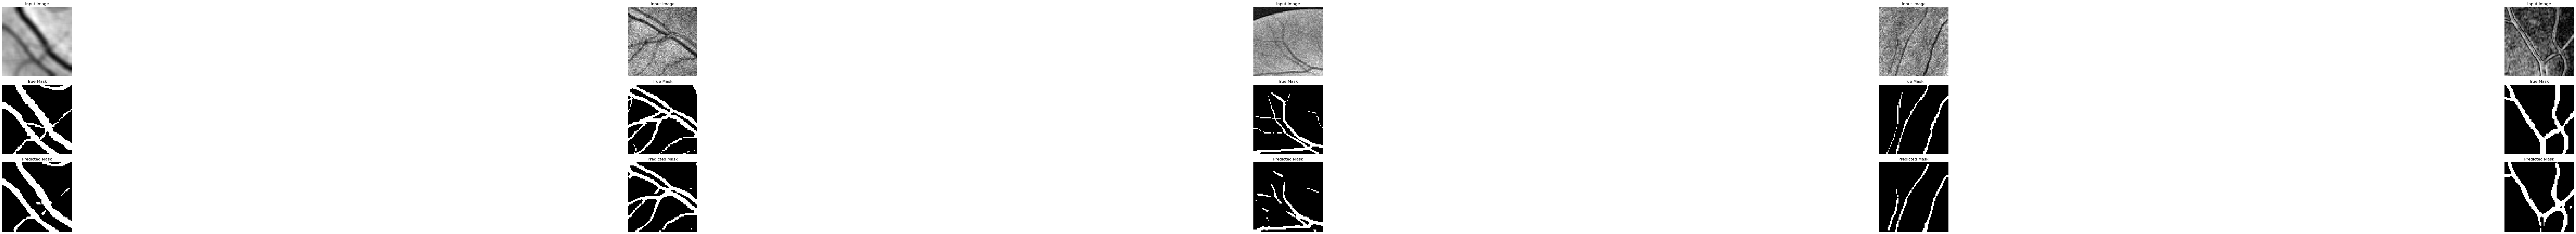

In [ ]:
# show 5 predictions with their masks and binarize
import matplotlib.pyplot as plt
def show_predictions(model, X, Y, num=50):
    preds = model.predict(X[:num])
    plt.figure(figsize=(150, 10))
    for i in range(num):
        plt.subplot(3, num, i + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(3, num, i + 1 + num)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(3, num, i + 1 + 2 * num)
        # binarize the prediction
        preds[i] = (preds[i] > 0.5).astype(np.float32)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, X_val, Y_val, num=5)


38/38 [==============================] - 0s 12ms/step


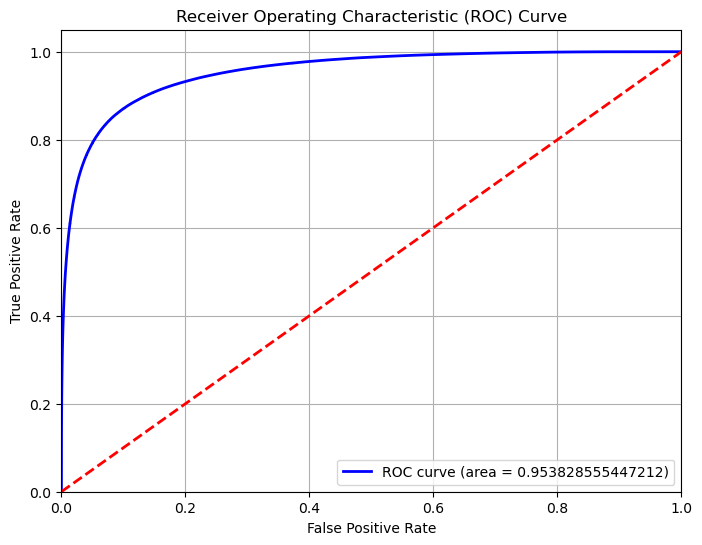

In [ ]:
# get roc curve
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true.flatten(), y_scores.flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot ROC curve for validation set
y_scores = model.predict(X_val)
y_true = Y_val
plot_roc_curve(y_true, y_scores)


